## Problem Statement:

Medical decisioning depends on medical history of a patient. Doctors typically use past patient records from multiple visits collected through lab tests, procedures and patient diagnoses records to determine the right treatment. The medical history and patient demographics can be used to identify and analyse patterns that groups patients into cohorts.

The cohorts formed vary in terms of diseases, test results and patient data. Electronic Health Records are a systematic way to collect huge amounts of digital health information from multiple sources. Accessing this data and using it to create the cohorts presents initial analysis and proper medical path to be followed for any patient dependingon the results from similar patients belonging to the same cohort.

The problem is clearly identified as an unsupervised machine learning problem and I will use relevant algorithms to distinguish various cohorts based on their differences. Furthermore, this analysis can be used for drug analysis, identifying disease progression and much more.


## Import Libraries

In [1]:
!unzip SOMperf.zip
!python SOMperf/setup.py install
!pip install MiniSom
# in-built libraries
import json
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
from datetime import date
import math
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
# external libraries
# pip install -r requirements.txt
from minisom import MiniSom
# downloaded from https://github.com/FlorentF9/SOMperf.git
from SOMperf.somperf.metrics import *
from SOMperf.somperf.utils.topology import rectangular_topology_dist

Archive:  SOMperf.zip
   creating: SOMperf/.git/
  inflating: SOMperf/.git/config     
  inflating: SOMperf/.git/description  
 extracting: SOMperf/.git/HEAD       
   creating: SOMperf/.git/hooks/
  inflating: SOMperf/.git/hooks/applypatch-msg.sample  
  inflating: SOMperf/.git/hooks/commit-msg.sample  
  inflating: SOMperf/.git/hooks/fsmonitor-watchman.sample  
  inflating: SOMperf/.git/hooks/post-update.sample  
  inflating: SOMperf/.git/hooks/pre-applypatch.sample  
  inflating: SOMperf/.git/hooks/pre-commit.sample  
  inflating: SOMperf/.git/hooks/pre-merge-commit.sample  
  inflating: SOMperf/.git/hooks/prepare-commit-msg.sample  
  inflating: SOMperf/.git/hooks/pre-push.sample  
  inflating: SOMperf/.git/hooks/pre-rebase.sample  
  inflating: SOMperf/.git/hooks/pre-receive.sample  
  inflating: SOMperf/.git/hooks/push-to-checkout.sample  
  inflating: SOMperf/.git/hooks/update.sample  
  inflating: SOMperf/.git/index      
   creating: SOMperf/.git/info/
  inflating: SOMperf/.gi

## Import Data

In [2]:
# There are 4 different text files each with data separated by tab space which we will import into individual datasets
admissions_df = pd.read_csv("AdmissionsCorePopulatedTable.txt", sep="\t")
diagnoses_df = pd.read_csv("AdmissionsDiagnosesCorePopulatedTable.txt", sep="\t")
labs_df = pd.read_csv("LabsCorePopulatedTable.txt", sep="\t")
patient_df = pd.read_csv("PatientCorePopulatedTable.txt", sep="\t")
patient_df.head()

,PatientID,PatientGender,PatientDateOfBirth,PatientRace,PatientMaritalStatus,PatientLanguage,PatientPopulationPercentageBelowPoverty
0,FB2ABB23-C9D0-4D09-8464-49BF0B982F0F,Male,1947-12-28 02:45:40.547,Unknown,Married,Icelandic,18.08
1,64182B95-EB72-4E2B-BE77-8050B71498CE,Male,1952-01-18 19:51:12.917,African American,Separated,English,13.03
2,DB22A4D9-7E4D-485C-916A-9CD1386507FB,Female,1970-07-25 13:04:20.717,Asian,Married,English,6.67
3,6E70D84D-C75F-477C-BC37-9177C3698C66,Male,1979-01-04 05:45:29.580,White,Married,English,16.09
4,C8556CC0-32FC-4CA5-A8CD-9CCF38816167,Female,1921-04-11 11:39:49.197,White,Married,English,18.20


In [3]:
admissions_df.head()

,PatientID,AdmissionID,AdmissionStartDate,AdmissionEndDate
0,7A025E77-7832-4F53-B9A7-09A3F98AC17E,7,2011-10-12 14:55:02.027,2011-10-22 01:16:07.557
1,DCE5AEB8-6DB9-4106-8AE4-02CCC5C23741,1,1993-02-11 18:57:04.003,1993-02-24 17:22:29.713
2,DCE5AEB8-6DB9-4106-8AE4-02CCC5C23741,2,2002-11-28 19:06:31.117,2002-12-04 19:14:40.797
3,DCE5AEB8-6DB9-4106-8AE4-02CCC5C23741,3,2011-07-19 18:42:45.287,2011-07-25 04:57:42.053
4,886B5885-1EE2-49F3-98D5-A2F02EB8A9D4,1,1994-12-03 22:20:46.077,1994-12-20 20:24:56.010


In [4]:
diagnoses_df.head()

,PatientID,AdmissionID,PrimaryDiagnosisCode,PrimaryDiagnosisDescription
0,80AC01B2-BD55-4BE0-A59A-4024104CF4E9,2,M01.X,Direct infection of joint in infectious and pa...
1,80AC01B2-BD55-4BE0-A59A-4024104CF4E9,3,D65,Disseminated intravascular coagulation [defibr...
2,80AC01B2-BD55-4BE0-A59A-4024104CF4E9,4,C92.1,"Chronic myeloid leukemia, BCR/ABL-positive"
3,80AC01B2-BD55-4BE0-A59A-4024104CF4E9,5,M05.51,Rheumatoid polyneuropathy with rheumatoid arth...
4,6A57AC0C-57F3-4C19-98A1-51135EFBC4FF,1,C91.00,Acute lymphoblastic leukemia not having achiev...


## Data Cleaning

In [5]:
# Function to calculate age compared to todays date
def calculate_age(birth_date):
        today = date.today()
        age = today.year - birth_date.year
        full_year_passed = (today.month, today.day) < (birth_date.month, birth_date.day)
        if not full_year_passed:
            age -= 1
        return age

In [6]:
# Adding the age column to the dataset
myFmt = mdates.DateFormatter('%d')
patient_df["PatientDateOfBirth"] = patient_df["PatientDateOfBirth"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))
patient_df["Age"] = patient_df["PatientDateOfBirth"].apply(calculate_age)

Converting AdmissionStartDate and AdmissionEndDate into datetime64 format to calculate the number of hours spent in admission

In [7]:
admissions_df["AdmissionStartDate"] = admissions_df["AdmissionStartDate"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))
admissions_df["AdmissionEndDate"] = admissions_df["AdmissionEndDate"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))

In [8]:
admissions_df.dtypes

PatientID                     object
AdmissionID                    int64
AdmissionStartDate    datetime64[ns]
AdmissionEndDate      datetime64[ns]
dtype: object

In [9]:
admissions_df["num_hours"] = (admissions_df.AdmissionEndDate-admissions_df.AdmissionStartDate).astype('timedelta64[h]')

In [10]:
admissions_df.head()

,PatientID,AdmissionID,AdmissionStartDate,AdmissionEndDate,num_hours
0,7A025E77-7832-4F53-B9A7-09A3F98AC17E,7,2011-10-12 14:55:02.027,2011-10-22 01:16:07.557,226.0
1,DCE5AEB8-6DB9-4106-8AE4-02CCC5C23741,1,1993-02-11 18:57:04.003,1993-02-24 17:22:29.713,310.0
2,DCE5AEB8-6DB9-4106-8AE4-02CCC5C23741,2,2002-11-28 19:06:31.117,2002-12-04 19:14:40.797,144.0
3,DCE5AEB8-6DB9-4106-8AE4-02CCC5C23741,3,2011-07-19 18:42:45.287,2011-07-25 04:57:42.053,130.0
4,886B5885-1EE2-49F3-98D5-A2F02EB8A9D4,1,1994-12-03 22:20:46.077,1994-12-20 20:24:56.010,406.0


## Visualization and Analysis

### Patient Data Distribution

<BarContainer object of 4 artists>

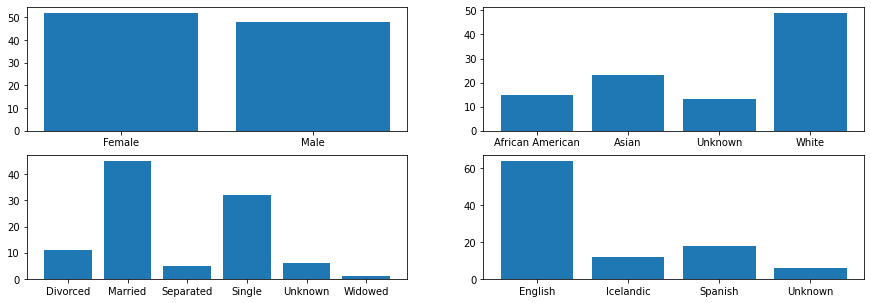

In [11]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,5))
patient_grouped_df = patient_df.groupby('PatientGender')['PatientID'].nunique().reset_index()
ax1.bar(patient_grouped_df["PatientGender"],patient_grouped_df["PatientID"])
patient_grouped_df = patient_df.groupby('PatientRace')['PatientID'].nunique().reset_index()
ax2.bar(patient_grouped_df["PatientRace"],patient_grouped_df["PatientID"])
patient_grouped_df = patient_df.groupby('PatientMaritalStatus')['PatientID'].nunique().reset_index()
ax3.bar(patient_grouped_df["PatientMaritalStatus"],patient_grouped_df["PatientID"])
patient_grouped_df = patient_df.groupby('PatientLanguage')['PatientID'].nunique().reset_index()
ax4.bar(patient_grouped_df["PatientLanguage"],patient_grouped_df["PatientID"])

The graphs show distribution of categories across the patients. The goal is to understand why some groups are favoured compared to others

Creating age groups - Grouping creates categories of ages for better clustering

<BarContainer object of 9 artists>

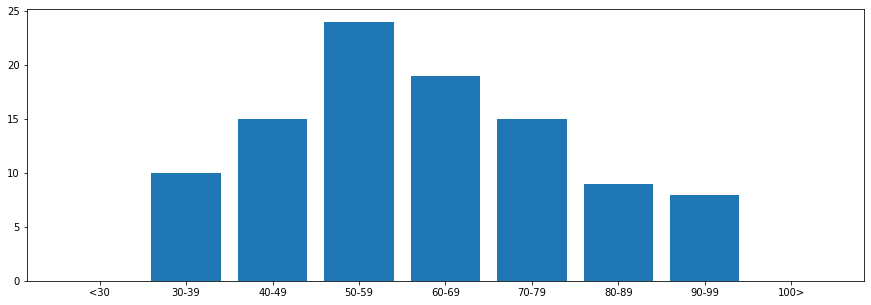

In [12]:
bins = [0, 30, 40, 50, 60, 70, 80, 90, 100, 120]
labels = ['<30', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99', '100>']
patient_df['AgeRange'] = pd.cut(patient_df.Age, bins, labels = labels,include_lowest = True)

plt.figure(figsize=(15,5))
patient_grouped_df = patient_df.groupby('AgeRange')['PatientID'].nunique().reset_index()
plt.bar(patient_grouped_df["AgeRange"],patient_grouped_df["PatientID"])

### Admission Data Distribution

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


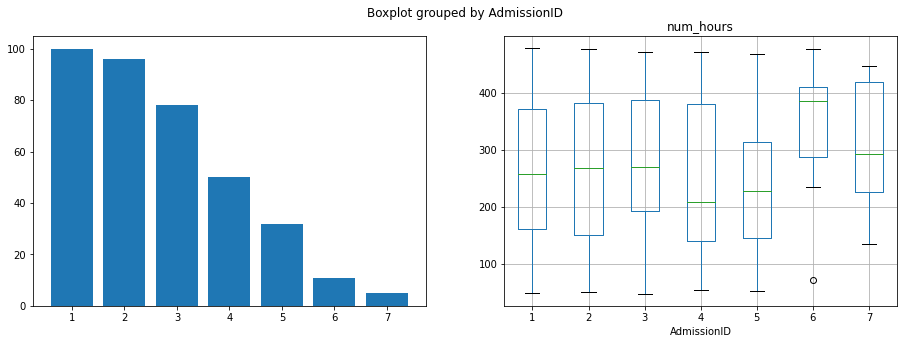

In [13]:
f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,5))
admission_grouped_df = admissions_df.groupby('AdmissionID')['PatientID'].nunique().reset_index()
ax1.bar(admission_grouped_df["AdmissionID"],admission_grouped_df["PatientID"])
admissions_df.boxplot(column=['num_hours'], by='AdmissionID', ax=ax2)

The bar chart shows the earlier visits to have more patients. The boxplot shows the visit number which takes up most of the time.

### Diagnosis Data Distribution

In [14]:
diagnoses_grouped_df = diagnoses_df.groupby('PrimaryDiagnosisCode')['PatientID'].nunique().reset_index()
diagnoses_grouped_df.head()

,PrimaryDiagnosisCode,PatientID
0,A42.0,1
1,A48.2,1
2,A52.0,1
3,A83.6,1
4,A98.3,1


Dividing the PrimaryDiagnosisCode into multiple columns to be able to create better clusters

In [15]:
diagnoses_df["OverallDiagnosisCode"] = diagnoses_df["PrimaryDiagnosisCode"].str[0]

diagnoses_df["DiagnosisCode1"] = diagnoses_df["PrimaryDiagnosisCode"].str.split(".")
diagnoses_df["DiagnosisCode1"] = diagnoses_df["DiagnosisCode1"].apply(lambda x: x[0])

diagnoses_df["DiagnosisCode2"] = diagnoses_df["PrimaryDiagnosisCode"].str.split(".")
diagnoses_df["DiagnosisCode2"] = diagnoses_df["DiagnosisCode2"].apply(lambda x: "" if len(x) < 2 else x[1])

diagnoses_df.head()

,PatientID,AdmissionID,PrimaryDiagnosisCode,PrimaryDiagnosisDescription,OverallDiagnosisCode,DiagnosisCode1,DiagnosisCode2
0,80AC01B2-BD55-4BE0-A59A-4024104CF4E9,2,M01.X,Direct infection of joint in infectious and pa...,M,M01,X
1,80AC01B2-BD55-4BE0-A59A-4024104CF4E9,3,D65,Disseminated intravascular coagulation [defibr...,D,D65,
2,80AC01B2-BD55-4BE0-A59A-4024104CF4E9,4,C92.1,"Chronic myeloid leukemia, BCR/ABL-positive",C,C92,1
3,80AC01B2-BD55-4BE0-A59A-4024104CF4E9,5,M05.51,Rheumatoid polyneuropathy with rheumatoid arth...,M,M05,51
4,6A57AC0C-57F3-4C19-98A1-51135EFBC4FF,1,C91.00,Acute lymphoblastic leukemia not having achiev...,C,C91,00


Understanding the common OverallDiagnosisCode among different patients

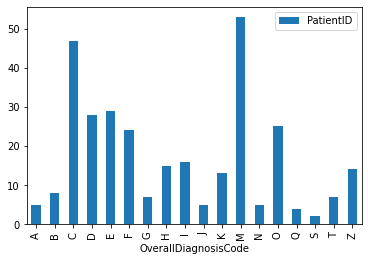

In [16]:
diagnoses_grouped_df = diagnoses_df.groupby('OverallDiagnosisCode')['PatientID'].nunique().reset_index()
diagnoses_grouped_df.plot.bar(x="OverallDiagnosisCode" , y="PatientID")

In [17]:
diagnoses_df[diagnoses_df["OverallDiagnosisCode"] == "Z"].head(15)

,PatientID,AdmissionID,PrimaryDiagnosisCode,PrimaryDiagnosisDescription,OverallDiagnosisCode,DiagnosisCode1,DiagnosisCode2
38,9C75DF1F-9DA6-4C98-8F5B-E10BDC805ED0,1,Z13.810,Encounter for screening for upper gastrointest...,Z,Z13,810
40,A19A0B00-4C9A-4206-B1FE-17E6DA3CEB0B,1,Z13.83,Encounter for screening for respiratory disord...,Z,Z13,83
54,FA157FA5-F488-4884-BF87-E144630D595C,5,Z13.85,Encounter for screening for nervous system dis...,Z,Z13,85
64,DA6CECFF-DE13-4C4C-919F-64E1A2B76C9D,4,Z22.31,Carrier of bacterial disease due to meningococci,Z,Z22,31
88,25B786AF-0F99-478C-9CFA-0EA607E45834,6,Z22.31,Carrier of bacterial disease due to meningococci,Z,Z22,31
135,69B5D2A0-12FD-46EF-A5FF-B29C4BAFBE49,1,Z91.15,Patient's noncompliance with renal dialysis,Z,Z91,15
141,8D389A8C-A6D8-4447-9DDE-1A28AB4EC667,2,Z13.22,Encounter for screening for metabolic disorder,Z,Z13,22
157,49DADA25-F2C2-42BB-8210-D78E6C7B0D48,1,Z12,Encounter for screening for malignant neoplasms,Z,Z12,
218,9E18822E-7D13-45C7-B50E-F95CFF92BC3E,1,Z13.0,Encounter for screening for diseases of the bl...,Z,Z13,0
229,98F593D2-8894-49BB-93B9-5A0E2CF85E2E,1,Z12.2,Encounter for screening for malignant neoplasm...,Z,Z12,2


The splitting of PrimaryDiagnosis to different columns makes sense when looking at the data above.
For example the rows 2, 3 & 7 show how the descriptions vary with the specific detail when you compare the codes

## Data Preparation

Combining the datasets into one dataframe

In [18]:
admitted_diagnoses_df = pd.merge(admissions_df,diagnoses_df,on=['PatientID','AdmissionID'], how='left')
admitted_diagnoses_df.drop(columns=["AdmissionStartDate", "AdmissionEndDate", "PrimaryDiagnosisCode", "PrimaryDiagnosisDescription"], inplace=True)
admit_patient_diag_df = pd.merge(admitted_diagnoses_df,patient_df,on=['PatientID'], how='left')
admit_patient_diag_df.drop(columns=["PatientDateOfBirth", "PatientPopulationPercentageBelowPoverty", "Age"], inplace=True)
# admit_patient_lab_diag_df = pd.merge(admit_patient_diag_df, labs_df, on=['PatientID', 'AdmissionID'], how='left')
# admit_patient_lab_diag_df.drop(columns=["PatientID", "LabUnits", "LabDateTime"], inplace=True)
admit_patient_diag_df.head()

,PatientID,AdmissionID,num_hours,OverallDiagnosisCode,DiagnosisCode1,DiagnosisCode2,PatientGender,PatientRace,PatientMaritalStatus,PatientLanguage,AgeRange
0,7A025E77-7832-4F53-B9A7-09A3F98AC17E,7,226.0,F,F06,3,Female,Asian,Single,English,60-69
1,DCE5AEB8-6DB9-4106-8AE4-02CCC5C23741,1,310.0,K,K91,,Female,White,Single,Unknown,50-59
2,DCE5AEB8-6DB9-4106-8AE4-02CCC5C23741,2,144.0,F,F40,01,Female,White,Single,Unknown,50-59
3,DCE5AEB8-6DB9-4106-8AE4-02CCC5C23741,3,130.0,C,C40,11,Female,White,Single,Unknown,50-59
4,886B5885-1EE2-49F3-98D5-A2F02EB8A9D4,1,406.0,M,M05,752,Female,Unknown,Married,English,40-49


In [19]:
admit_patient_diag_df.shape

(372, 11)

In [20]:
admit_patient_diag_df.dtypes

PatientID                 object
AdmissionID                int64
num_hours                float64
OverallDiagnosisCode      object
DiagnosisCode1            object
DiagnosisCode2            object
PatientGender             object
PatientRace               object
PatientMaritalStatus      object
PatientLanguage           object
AgeRange                category
dtype: object

Converting the string values into categories and later into integers with integer encoding 

In [21]:
admit_patient_diag_df["OverallDiagnosisCode"] = admit_patient_diag_df["OverallDiagnosisCode"].astype('category')
admit_patient_diag_df["DiagnosisCode1"] = admit_patient_diag_df["DiagnosisCode1"].astype('category')
admit_patient_diag_df["DiagnosisCode2"] = admit_patient_diag_df["DiagnosisCode2"].astype('category')
admit_patient_diag_df["PatientGender"] = admit_patient_diag_df["PatientGender"].astype('category')
admit_patient_diag_df["PatientRace"] = admit_patient_diag_df["PatientRace"].astype('category')
admit_patient_diag_df["PatientMaritalStatus"] = admit_patient_diag_df["PatientMaritalStatus"].astype('category')
admit_patient_diag_df["PatientLanguage"] = admit_patient_diag_df["PatientLanguage"].astype('category')

In [22]:
overall_diag_code_dict = dict(enumerate(admit_patient_diag_df["OverallDiagnosisCode"].cat.categories))
diag_code_1_dict = dict(enumerate(admit_patient_diag_df["DiagnosisCode1"].cat.categories))
diag_code_2_dict = dict(enumerate(admit_patient_diag_df["DiagnosisCode2"].cat.categories))
gender_dict = dict(enumerate(admit_patient_diag_df["PatientGender"].cat.categories))
race_dict = dict(enumerate(admit_patient_diag_df["PatientRace"].cat.categories))
marital_status_dict = dict(enumerate(admit_patient_diag_df["PatientMaritalStatus"].cat.categories))
lang_dict = dict(enumerate(admit_patient_diag_df["PatientLanguage"].cat.categories))
age_dict = dict(enumerate(admit_patient_diag_df["AgeRange"].cat.categories))

category_dict = {"overall_diag_code_dict":overall_diag_code_dict, "diag_code_1_dict":diag_code_1_dict, "diag_code_2_dict":diag_code_1_dict, "gender_dict": gender_dict, "race_dict":race_dict, "marital_status_dict":marital_status_dict, "lang_dict":lang_dict, "age_dict":age_dict}
categories_file = open("categories_data.json", "w")
categories_file = json.dump(category_dict, categories_file)

In [23]:
admit_patient_diag_df["OverallDiagnosisCode_cat"] = admit_patient_diag_df["OverallDiagnosisCode"].cat.codes
admit_patient_diag_df["DiagnosisCode1_cat"] = admit_patient_diag_df["DiagnosisCode1"].cat.codes
admit_patient_diag_df["DiagnosisCode2_cat"] = admit_patient_diag_df["DiagnosisCode2"].cat.codes
admit_patient_diag_df["PatientGender_cat"] = admit_patient_diag_df["PatientGender"].cat.codes
admit_patient_diag_df["PatientRace_cat"] = admit_patient_diag_df["PatientRace"].cat.codes
admit_patient_diag_df["PatientMaritalStatus_cat"] = admit_patient_diag_df["PatientMaritalStatus"].cat.codes
admit_patient_diag_df["PatientLanguage_cat"] = admit_patient_diag_df["PatientLanguage"].cat.codes
admit_patient_diag_df["AgeRange_cat"] = admit_patient_diag_df["AgeRange"].cat.codes

## Modeling

### Data Preprocessing

In [24]:
input_df = admit_patient_diag_df[['AdmissionID', 'OverallDiagnosisCode_cat', 'DiagnosisCode1_cat',
                                      'DiagnosisCode2_cat', 'PatientGender_cat', 'PatientRace_cat',
                                      'PatientMaritalStatus_cat', 'PatientLanguage_cat', 'AgeRange_cat']]

In [25]:
input_df.shape

(372, 9)

In [26]:
input_df.columns

Index(['AdmissionID', 'OverallDiagnosisCode_cat', 'DiagnosisCode1_cat',
       'DiagnosisCode2_cat', 'PatientGender_cat', 'PatientRace_cat',
       'PatientMaritalStatus_cat', 'PatientLanguage_cat', 'AgeRange_cat'],
      dtype='object')

In [27]:
input_df.head()

,AdmissionID,OverallDiagnosisCode_cat,DiagnosisCode1_cat,DiagnosisCode2_cat,PatientGender_cat,PatientRace_cat,PatientMaritalStatus_cat,PatientLanguage_cat,AgeRange_cat
0,7,5,78,48,0,1,3,0,4
1,1,10,133,0,0,3,3,3,3
2,2,5,90,3,0,3,3,3,3
3,3,2,27,18,0,3,3,3,3
4,1,11,136,111,0,2,1,0,2


In [28]:
# Converting dataframe to numpy array required for the model.
input_numpy_arr_data = input_df.values

### Initializing and training the model

In [29]:
# Using 6X6 neurons to learn from the data and create clusters
som = MiniSom(6, 6, input_len = input_df.shape[1], sigma=0.5, learning_rate=0.5, random_seed=999)
som.train_random(input_numpy_arr_data, 100)


In [30]:
# Saving model
filename = 'finalized_model.pkl'
pickle.dump(som, open(filename, 'wb'))

adding seed to the model to ensure the winner does not change between each run.

### Clustering a random data record

In [31]:
# Finding which neuron is the winner(closest) to the test data
print(input_numpy_arr_data[0])
som.winner(input_numpy_arr_data[0])

[ 7  5 78 48  0  1  3  0  4]


(2, 2)

### How good is SOM performing

In [32]:
weights = som.get_weights().reshape(6*6, -1)

# compute a few metrics
print('Topographic product = ', topographic_product(rectangular_topology_dist((6,6)), weights))
print('Neighborhood preservation = ', neighborhood_preservation(1, weights, input_numpy_arr_data))
print('Trustworthiness = ', trustworthiness(1, weights, input_numpy_arr_data))

Topographic product =  0.10889926693041899
Neighborhood preservation =  0.5353676256902064
Trustworthiness =  0.8467166623891109


Manhattan distance generally works only if the points are arranged in the form of a grid and the problem which we are working on gives more priority to the distance between the points only along with the grids, but not the geometric distance.This gives us 81% trustworthiness.

### DBSCAN - Density-Based Spatial Clustering of Applications with Noise

Comparing our results with another model gives us a good idea on how good the data actually is. I am using the DBSCAN model that decides the number of clusters within a dataset.

In [35]:
dbscan = DBSCAN(eps=6, min_samples=8)
# Fitting
dbscan.fit(input_df)
# Transoring Using PCA

clustering_labels = dbscan.fit_predict(input_df)
np.unique(clustering_labels)

array([-1,  0,  1,  2,  3,  4,  5])

In [36]:
metrics.silhouette_score(input_df, clustering_labels)

-0.39796160032464956

Using DBSCAN has given a silhouette score of -0.019. Silhouette score close to 1 indicates that the clusters decided by DBSCAN were good enough, but anything close to zero or negative shows that the algorithm chose either less number of clusters or too many.

This proves that our model is better in terms of assigning data points to their relavent clusters.

#### Visualizing DBSCAN clusters:

Text(0, 0.5, 'Feature 2')

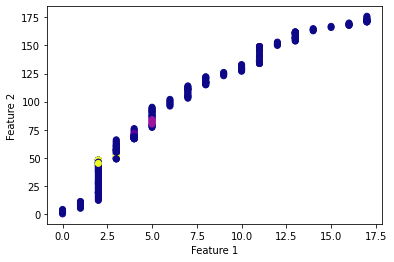

In [37]:
plt.scatter(input_df.iloc[:, 1], input_df.iloc[:, 2], c=clustering_labels, cmap="plasma")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

The DBSCAN cluster plot at first glance doesnt make much sense but if you look closely you will notice that the blue dots which represent error(-1) cluster falls all over the place but other nodes are fairly clustered. The reason why DBSCAN does not perform well is because the number of error/unclustered data points are high compared to the clustered ones

### Plotting MiniSOM clusters

In [38]:
labels = []
for i in range(input_df.shape[0]):
    labels.append(som.winner(input_numpy_arr_data[i]))
input_df["labels_som"] = labels

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [39]:
input_df.head()

,AdmissionID,OverallDiagnosisCode_cat,DiagnosisCode1_cat,DiagnosisCode2_cat,PatientGender_cat,PatientRace_cat,PatientMaritalStatus_cat,PatientLanguage_cat,AgeRange_cat,labels_som
0,7,5,78,48,0,1,3,0,4,"(2, 2)"
1,1,10,133,0,0,3,3,3,3,"(0, 2)"
2,2,5,90,3,0,3,3,3,3,"(1, 3)"
3,3,2,27,18,0,3,3,3,3,"(2, 3)"
4,1,11,136,111,0,2,1,0,2,"(1, 2)"


Text(0, 0.5, 'Feature 2')

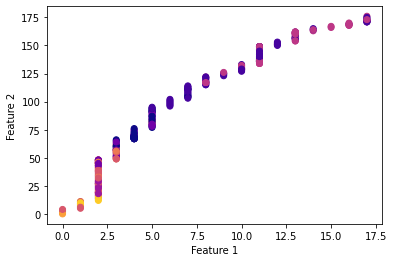

In [40]:
labels_list = pd.factorize(input_df['labels_som'].tolist())[0]
plt.scatter(input_df.iloc[:, 1], input_df.iloc[:, 2], c=labels_list, cmap="plasma")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

The SOM clusters are better defined compared to DBSCAN and this might be the driving factor for the model to perform well compared to DBSCAN.